# Building model and evaluation for Seattle Airbnb data

This process was carried out according to CRISP-DM
1. Business understand was carried out in detail in *'examine_the_data.ipynb'* file

## 2. Data understanding
* Following analysis and model building was carried out based on *'listing.csv'* provided by[kaggle.com](https://www.kaggle.com/airbnb/seattle)
* 'listing.csv' contains including full descriptions and average review score

In [1]:
#import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
#import dataset
df = pd.read_csv('listings.csv')

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
# % of null values by columns
pd.DataFrame(((np.sum(df.isnull()) / df.shape[0]) * 100), columns=['null%']).sort_values(by='null%', ascending=False)

,null%
license,100.000000
square_feet,97.459403
monthly_price,60.267156
security_deposit,51.126244
weekly_price,47.380828
...,...
room_type,0.000000
accommodates,0.000000
bed_type,0.000000
amenities,0.000000


In [5]:
#dropping null 75% greter than
df = df.drop(['license','square_feet'], axis=1)

#### Pairplot
* sns pairplot function was used to analyze price with property details.



In [ ]:
propfeatures_pairplot_df =  df[[ "price", "accommodates", "bathrooms", "bedrooms", "beds"]]

sns.pairplot(propfeatures_pairplot_df);

In [7]:
df.price

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

In [8]:
#since price coloumn contains unwanted charaters, it should be removed
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
print(df.price.describe())

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64


## Data Preparation


In [9]:
#remove unwanted columns
drop_list = ['id','listing_url','scrape_id', 'thumbnail_url','medium_url','picture_url','xl_picture_url', 'host_id', 'host_url']

In [10]:
df_drop = df.drop(drop_list, axis=1)

In [11]:
df_drop.shape

(3818, 81)

In [12]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - independet variable help the predict dependent variable
    y - dependent variable
    
    Followig steps will be carried out by this function
    1. Get the numerical variable
    2. Fill the missing values with mean
    3. Get the categorical variables
    4. Creates dummy columns for the categorical variables
    5. Creates X with independent variables
    6. Creates y with the price column values

    '''
  
    num_vars= df.select_dtypes(include=['int','float']).copy().columns

   
    for var in num_vars:
        df[var].fillna((df[var].mean()), inplace=True)

   
    cat_vars = df.select_dtypes(include=['object']).copy().columns

   
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
   
    X = df.drop(columns=['price'], axis=1)
    y = df['price']
    
    return X, y

In [13]:
X,y = clean_data(df_drop)


In [14]:
X.shape, y.shape


((3818, 39216), (3818,))

## Data Modeling

* My selection is Random Forest Regressor for preditction of price


In [15]:
#Before go for modeling let's scale value using standardscaler
scaler = StandardScaler().fit(X)
X_scaled=scaler.transform(X)

In [16]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state=56)

In [17]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((2672, 39216), (2672,), (1146, 39216), (1146,))

In [18]:
#Instantiate the Random Forest Regressor Model
model_rf = RandomForestRegressor(n_jobs=-1)

In [19]:
model_rf.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

## Model Evaluation

In [20]:
#predict y_train 
y_train_preds=model_rf.predict(X_train)
#evalatue y_train_preds
print("The r-squared score for the training data: {} . The RMSE : {}".format(r2_score(y_train, y_train_preds), mean_squared_error(y_train, y_train_preds)))


The r-squared score for the training data: 0.940937774150822 . The RMSE : 459.9922820733533


In [21]:
#predict y_test
y_test_preds = model_rf.predict(X_test)
#evaluate y_test_preds
print("The r-squared score for the test data was {} .  The RMSE : {}".format(r2_score(y_test, y_test_preds), mean_squared_error(y_test, y_test_preds)))


The r-squared score for the test data was 0.647122050994729 .  The RMSE : 3164.528127748691


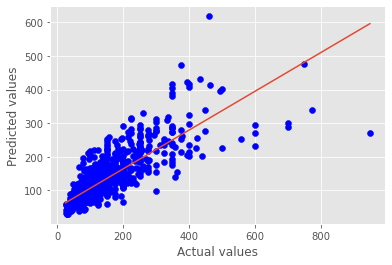

In [35]:
#scatter plot with y_test vs y_test_preds
plt1=plt.style.use('ggplot')
plt1=plt.scatter(y_test, y_test_preds, c='blue')
plt1=plt.xlabel('Actual values')
plt1=plt.ylabel('Predicted values')
plt1=plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_preds, 1))(np.unique(y_test)));

### Residual values vs predicted values
The following plot was created using user submitted solution at [Kaggle.com](https://www.kaggle.com/yifanma/predicting-listing-prices)

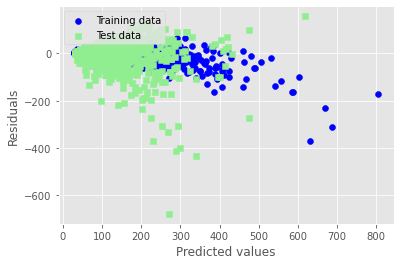

In [26]:

plt.style.use('ggplot')
plt.scatter(y_train_preds,  y_train_preds - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_preds,  y_test_preds - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()